## Group ML Challenge

## Telcom Churn Prediction

Objective

Answer the following questions:

Which customers(their demographic characteristics, the services they use, the duration of using the operator's services, the method of payment, and the amount of payment) are likely to churn? 

What are the attributes that make you think so?

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
downloaded = drive.CreateFile({'id':"153mUUe7aLo-xeTz1UArUqiUpOrPXnKgr"})
downloaded.GetContentFile('telecom_users.csv')
#https://drive.google.com/file/d/153mUUe7aLo-xeTz1UArUqiUpOrPXnKgr/view?usp=sharing

customerID - customer id

gender - client gender (male / female)

SeniorCitizen - is the client retired (1, 0)

Partner - is the client married (Yes, No)

tenure - how many months a person has been a client of the company

PhoneService - is the telephone service connected (Yes, No)

MultipleLines - are multiple phone lines connected (Yes, No, No phone service)

InternetService - client’s Internet service provider (DSL, Fiber optic, No)

OnlineSecurity - is the online security service connected (Yes, No, No internet service)

OnlineBackup - is the online backup service activated (Yes, No, No internet service)

DeviceProtection - does the client have equipment insurance (Yes, No, No internet service)

TechSupport - is the technical support service connected (Yes, No, No internet service)

StreamingTV - is the streaming TV service connected (Yes, No, No internet service)

StreamingMovies - is the streaming cinema service activated (Yes, No, No internet service)

Contract - type of customer contract (Month-to-month, One year, Two year)

PaperlessBilling - whether the client uses paperless billing (Yes, No)

PaymentMethod - payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))

MonthlyCharges - current monthly payment

TotalCharges - the total amount that the client paid for the services for the entire time

Churn - whether there was a churn (Yes or No)



In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import scipy

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.pipeline import Pipeline
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score, confusion_matrix, precision_score, f1_score

#from sklearn.datasets import make_classification
#from sklearn.datasets.samples_generator import make_blobs

## Load Data

In [4]:
df = pd.read_csv('telecom_users.csv', index_col=0)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5986 entries, 1869 to 860
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5986 non-null   object 
 1   gender            5986 non-null   object 
 2   SeniorCitizen     5986 non-null   int64  
 3   Partner           5986 non-null   object 
 4   Dependents        5986 non-null   object 
 5   tenure            5986 non-null   int64  
 6   PhoneService      5986 non-null   object 
 7   MultipleLines     5986 non-null   object 
 8   InternetService   5986 non-null   object 
 9   OnlineSecurity    5986 non-null   object 
 10  OnlineBackup      5986 non-null   object 
 11  DeviceProtection  5986 non-null   object 
 12  TechSupport       5986 non-null   object 
 13  StreamingTV       5986 non-null   object 
 14  StreamingMovies   5986 non-null   object 
 15  Contract          5986 non-null   object 
 16  PaperlessBilling  5986 non-null   object

In [6]:
df.shape

(5986, 21)

In [7]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## Data cleaning

In [9]:
clean_df=df.copy()

In [10]:
clean_df['TotalCharges'].unique()

array(['1734.65', '3973.2', '2869.85', ..., '306.05', '1200.15', '457.3'],
      dtype=object)

In [11]:
clean_df["TotalCharges"] = clean_df["TotalCharges"].replace(r' ', np.nan, regex=True)

In [12]:
clean_df["TotalCharges"] = clean_df["TotalCharges"].astype("float")

In [13]:
clean_df = clean_df.dropna(axis = 0, how ='any')
clean_df.shape

(5976, 21)

In [14]:
df_obj=clean_df.select_dtypes(include=['object'])
df_obj.head()

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
1869,7010-BRBUU,Male,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),No
4528,9688-YGXVR,Female,No,No,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),No
6344,9286-DOJGF,Female,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),Yes
6739,6994-KERXL,Male,No,No,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,No
432,2181-UAESM,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,No


In [15]:
df_num=clean_df.select_dtypes(exclude=['object'])
df_num.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
1869,0,72,24.10,1734.65
4528,0,44,88.15,3973.20
6344,1,38,74.95,2869.85
6739,0,4,55.90,238.50
432,0,2,53.45,119.50


In [16]:
df_obj.drop(columns='customerID')
for i in df_obj.columns:
  print(df_obj[i].unique())
  

['7010-BRBUU' '9688-YGXVR' '9286-DOJGF' ... '8044-BGWPI' '7450-NWRTR'
 '4795-UXVCJ']
['Male' 'Female']
['Yes' 'No']
['Yes' 'No']
['Yes' 'No']
['Yes' 'No' 'No phone service']
['No' 'Fiber optic' 'DSL']
['No internet service' 'No' 'Yes']
['No internet service' 'Yes' 'No']
['No internet service' 'Yes' 'No']
['No internet service' 'No' 'Yes']
['No internet service' 'Yes' 'No']
['No internet service' 'No' 'Yes']
['Two year' 'Month-to-month' 'One year']
['No' 'Yes']
['Credit card (automatic)' 'Bank transfer (automatic)' 'Electronic check'
 'Mailed check']
['No' 'Yes']


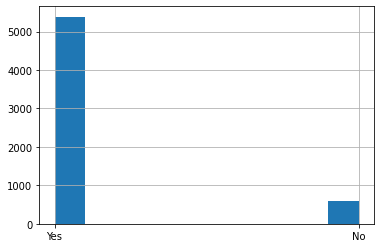

In [17]:
df_obj['PhoneService'].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d3c143c50>,
      dtype=object)

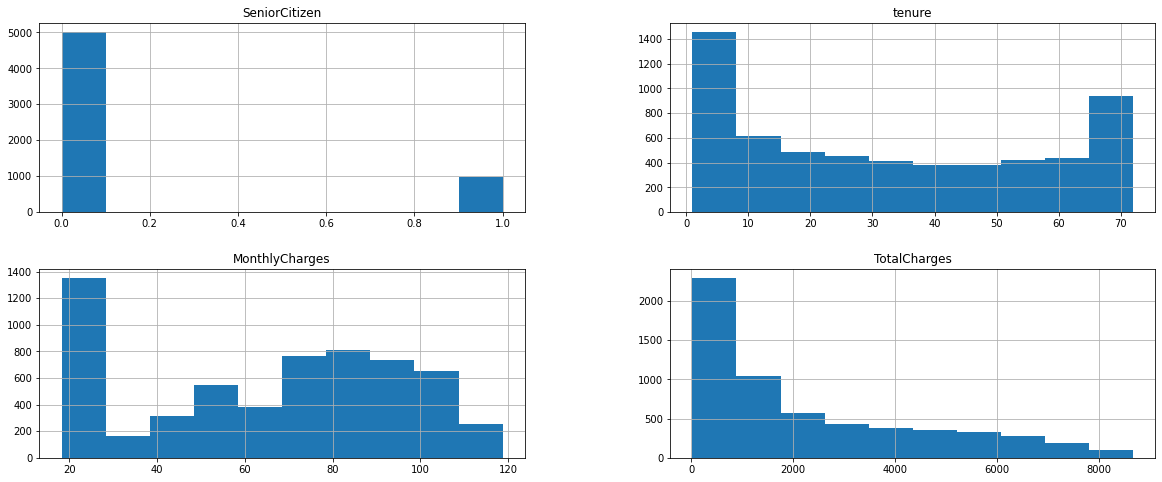

In [18]:
df_num.hist(figsize=(20,8))

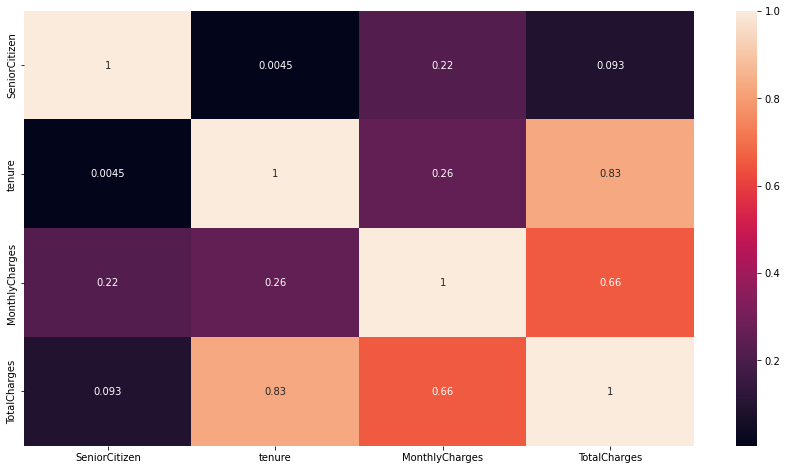

In [19]:
corr=df_num.corr()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(corr, annot=True,)

In [20]:
df_num['tenure'].unique()

array([72, 44, 38,  4,  2, 70, 33,  1, 39, 55, 52, 30, 60, 50, 32, 51, 69,
       42, 14, 62,  5, 63, 67, 40, 65, 16, 46, 11, 49, 68, 10, 53, 54, 15,
        3, 71,  8, 64, 57, 20, 26, 31,  7, 35,  6, 13, 23,  9, 45, 17, 34,
       58, 12, 25, 28, 29, 43, 19, 41, 37, 27, 22, 24, 18, 56, 66, 59, 48,
       47, 61, 21, 36])

In [21]:
df_dummy=clean_df


Text(0.5, 1.0, 'Churn')

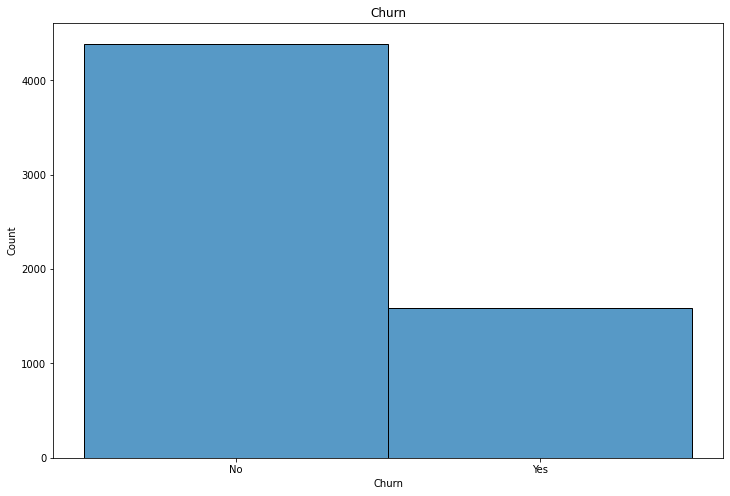

In [22]:

#df_dummy['Churn'].hist(figsize=(12,8),color=None, label=df_dummy['Churn'], )
#int_feat = df.select_dtypes(exclude=['object','category']).columns
fig, ax = plt.subplots(figsize=(12,8))
ax=sns.histplot(df_dummy['Churn'], ax=ax, bins=10)
ax.set_title('Churn')

    

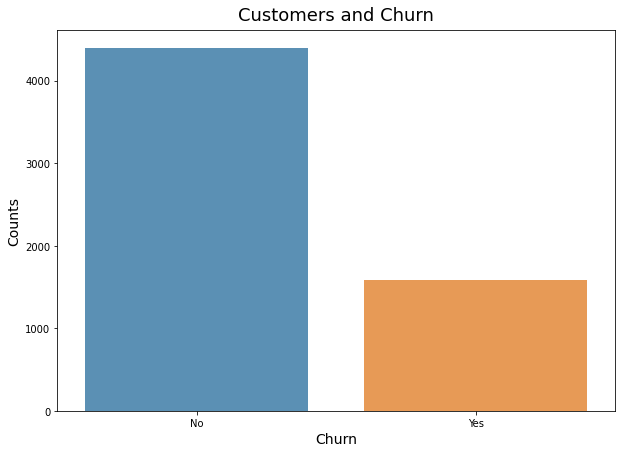

In [88]:
df_dummy['Churn'].replace({1: 'Yes',0: 'No'},inplace=True)
churn = df_dummy['Churn'].value_counts()
plt.figure(figsize=(10, 7))
sns.barplot(x=churn.index, y=churn.values, alpha=0.8)
plt.title('Customers and Churn', fontsize=18, pad=10)
plt.ylabel('Counts', fontsize=14)
plt.xlabel('Churn', fontsize=14)
plt.show()

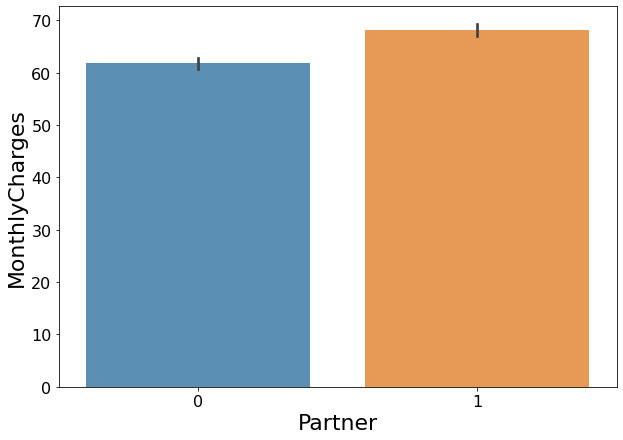

In [81]:
plt.figure(figsize=(10, 7))
sns.barplot(x=df_dummy['Partner'], y=df_dummy['MonthlyCharges'], alpha=0.8)
#plt.title('Customers and Churn', fontsize=18, pad=10)
plt.ylabel('MonthlyCharges', fontsize=22)
plt.xlabel('Partner', fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

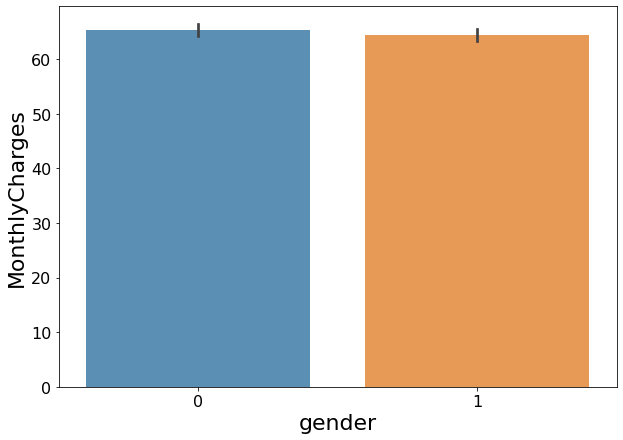

In [83]:
plt.figure(figsize=(10, 7))
sns.barplot(x=df_dummy['gender'], y=df_dummy['MonthlyCharges'], alpha=0.8)
#plt.title('Customers and Churn', fontsize=18, pad=10)
plt.ylabel('MonthlyCharges', fontsize=22)
plt.xlabel('gender', fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

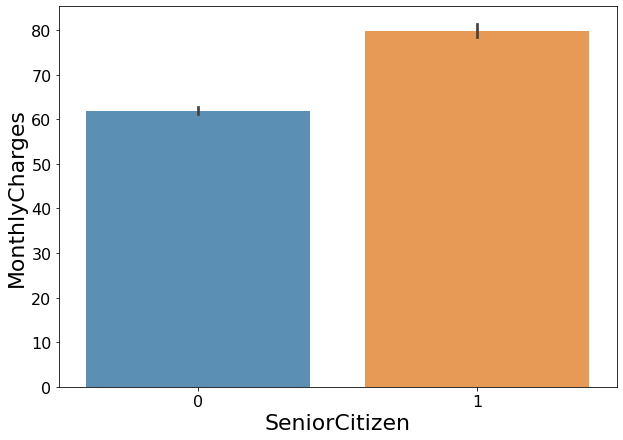

In [84]:
plt.figure(figsize=(10, 7))
sns.barplot(x=df_dummy['SeniorCitizen'], y=df_dummy['MonthlyCharges'], alpha=0.8)
#plt.title('Customers and Churn', fontsize=18, pad=10)
plt.ylabel('MonthlyCharges', fontsize=22)
plt.xlabel('SeniorCitizen', fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

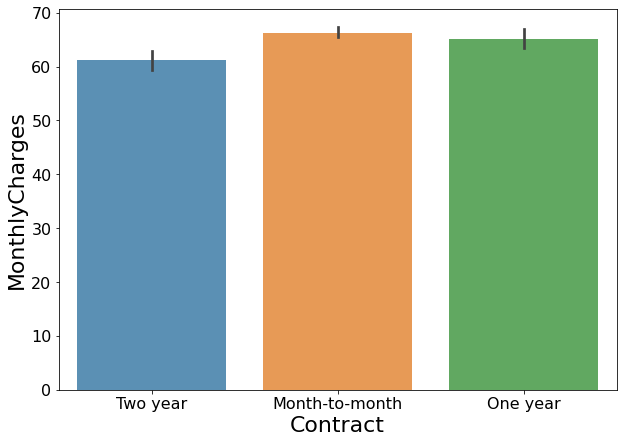

In [85]:
plt.figure(figsize=(10, 7))
sns.barplot(x=df_dummy['Contract'], y=df_dummy['MonthlyCharges'], alpha=0.8)
#plt.title('Customers and Churn', fontsize=18, pad=10)
plt.ylabel('MonthlyCharges', fontsize=22)
plt.xlabel('Contract', fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

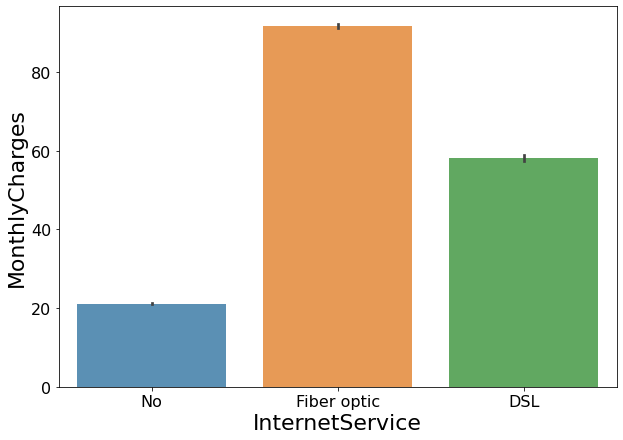

In [86]:
plt.figure(figsize=(10, 7))
sns.barplot(x=df_dummy['InternetService'], y=df_dummy['MonthlyCharges'], alpha=0.8)
#plt.title('Customers and Churn', fontsize=18, pad=10)
plt.ylabel('MonthlyCharges', fontsize=22)
plt.xlabel('InternetService', fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

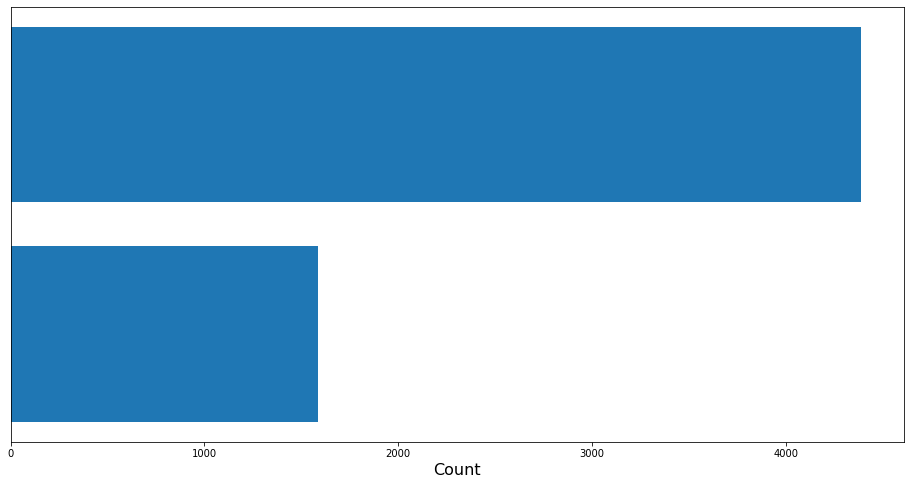

In [24]:
fig, ax = plt.subplots(figsize=(16,8))

# Example data
#people = ('Tom', 'Dick', 'Harry', 'Slim', 'Jim')
#y_pos = np.arange(len(people))
#performance = 3 + 10 * np.random.rand(len(people))
#error = np.random.rand(len(people))

ax.barh(churn.index, churn.values, align='center')
ax.set_yticks('Churn')
ax.set_yticklabels(churn.index)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Count',fontsize=16)
#ax.set_title('How fast do you want to go today?')

plt.show()

In [25]:
churn

No     4389
Yes    1587
Name: Churn, dtype: int64

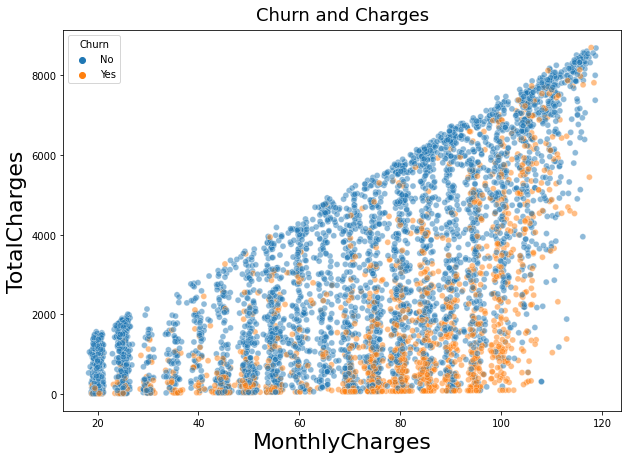

In [26]:
#fig, ax = plt.subplots(figsize=(12,8))
#ax=sns.scatterplot(data=df_dummy, x='MonthlyCharges', y='TotalCharges', hue='Churn', alpha=0.5)
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_dummy, x='MonthlyCharges', y='TotalCharges', hue='Churn', alpha=0.5,legend=True)
plt.title('Churn and Charges', fontsize=18, pad=10)
plt.ylabel('TotalCharges', fontsize=22)
plt.xlabel('MonthlyCharges', fontsize=22)
#plt.legend(fontsize=14)
plt.show()

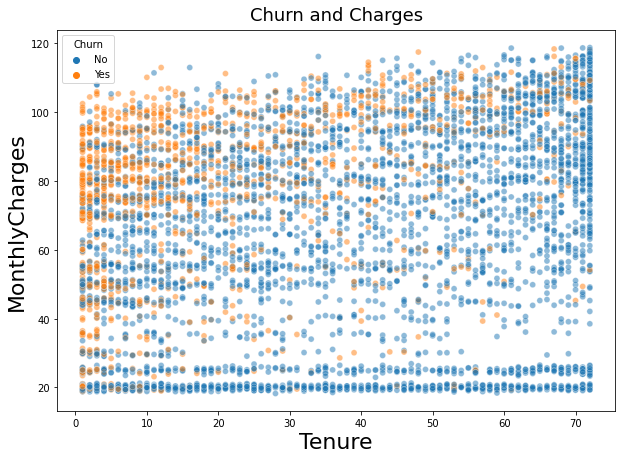

In [27]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_dummy, x='tenure', y='MonthlyCharges', hue='Churn', alpha=0.5,legend=True)
plt.title('Churn and Charges', fontsize=18, pad=10)
plt.ylabel('MonthlyCharges', fontsize=22)
plt.xlabel('Tenure', fontsize=22)
#plt.legend(fontsize=14)
plt.show()

Text(0.5, 0, 'Contract')

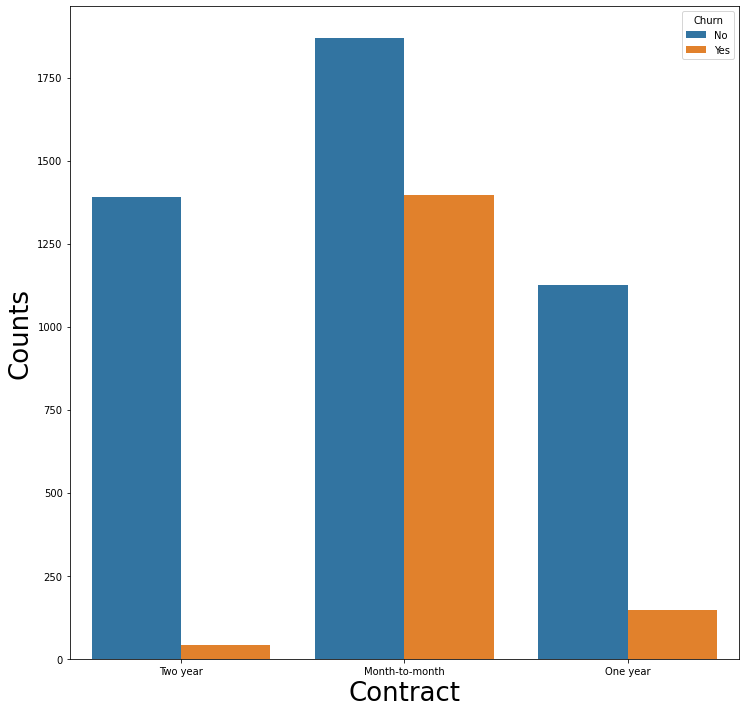

In [28]:
#cat_cols = df.select_dtypes(include=['object','category']).columns.to_list()
#cat_cols.remove('Churn')
fig, ax = plt.subplots(figsize=(12,12))
ax=sns.countplot(data=df_dummy,x='Contract', ax=ax, hue='Churn')
ax.set_ylabel('Counts', fontsize=26)
ax.set_xlabel('Contract', fontsize=26)

(array([   0.,  500., 1000., 1500., 2000., 2500.]),
 <a list of 6 Text major ticklabel objects>)

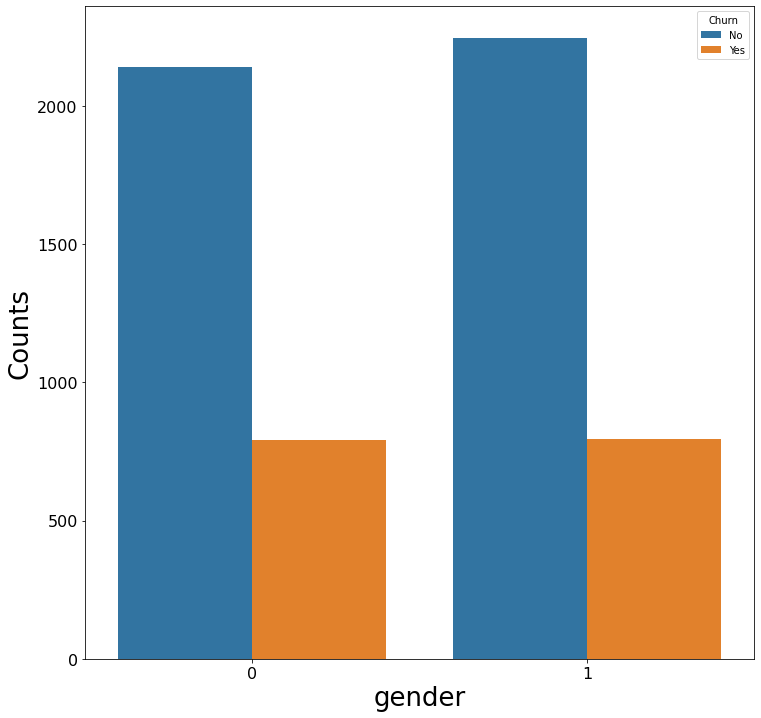

In [91]:
fig, ax = plt.subplots(figsize=(12,12))
ax=sns.countplot(data=df_dummy,x='gender', ax=ax, hue='Churn')
ax.set_ylabel('Counts', fontsize=26)
ax.set_xlabel('gender', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800.]), <a list of 10 Text major ticklabel objects>)

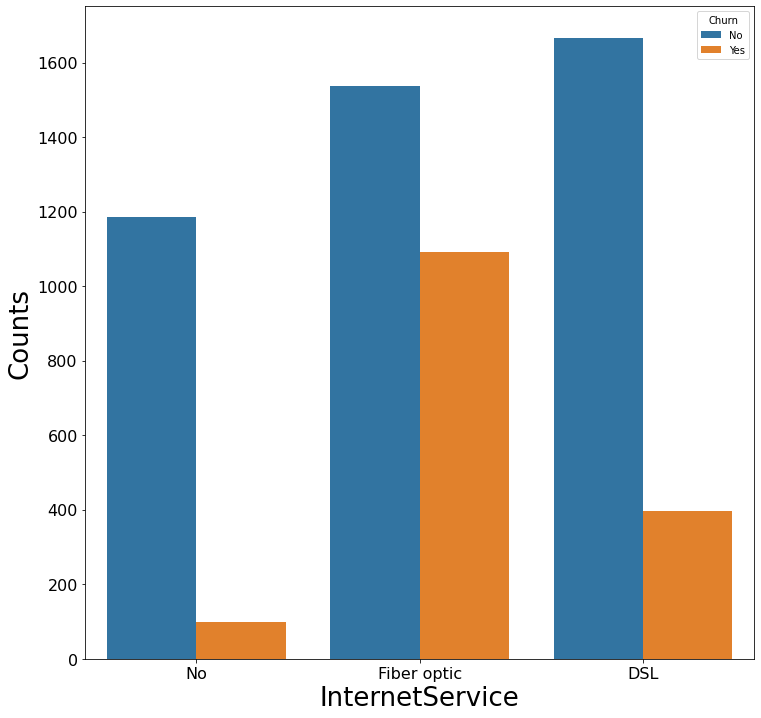

In [99]:
fig, ax = plt.subplots(figsize=(12,12))
ax=sns.countplot(data=df_dummy,x='InternetService', ax=ax, hue='Churn')
ax.set_ylabel('Counts', fontsize=26)
ax.set_xlabel('InternetService', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 <a list of 7 Text major ticklabel objects>)

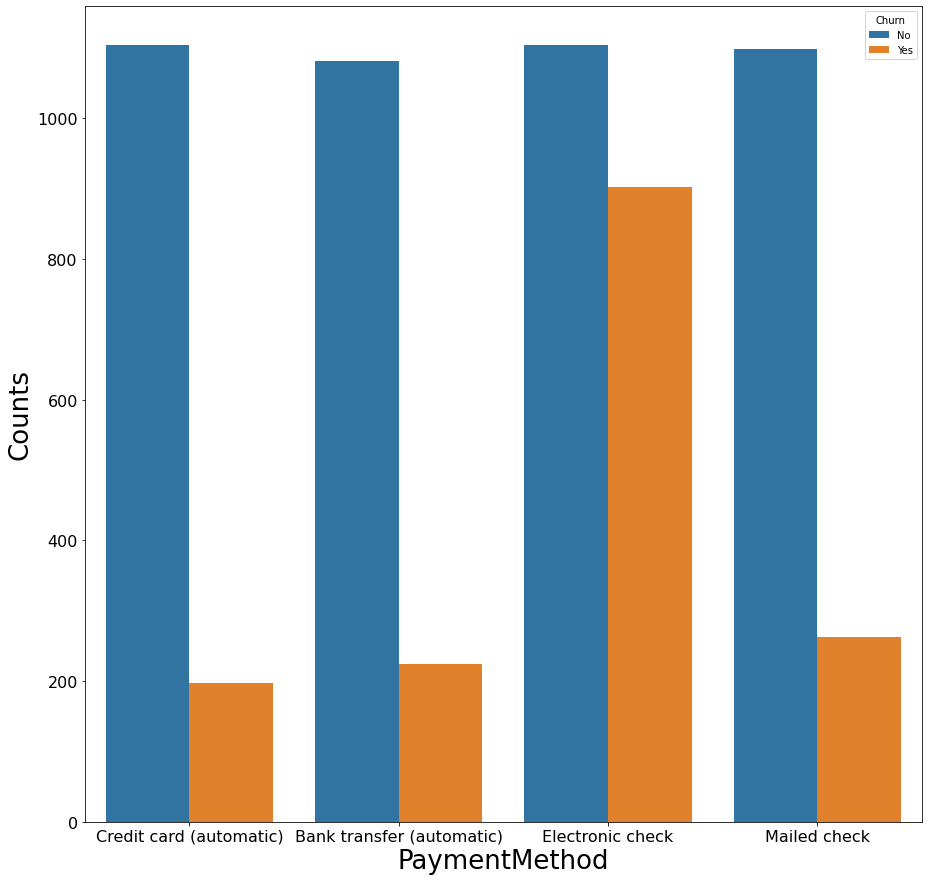

In [101]:
fig, ax = plt.subplots(figsize=(15,15))
ax=sns.countplot(data=df_dummy,x='PaymentMethod', ax=ax, hue='Churn')
ax.set_ylabel('Counts', fontsize=26)
ax.set_xlabel('PaymentMethod', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.,
        4500.]), <a list of 10 Text major ticklabel objects>)

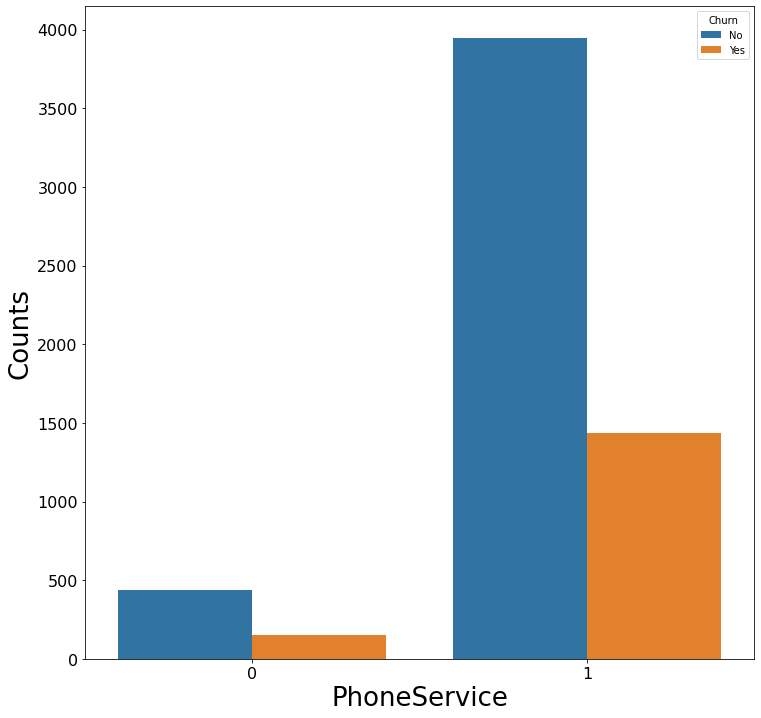

In [92]:
fig, ax = plt.subplots(figsize=(12,12))
ax=sns.countplot(data=df_dummy,x='PhoneService', ax=ax, hue='Churn')
ax.set_ylabel('Counts', fontsize=26)
ax.set_xlabel('PhoneService', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800.]), <a list of 10 Text major ticklabel objects>)

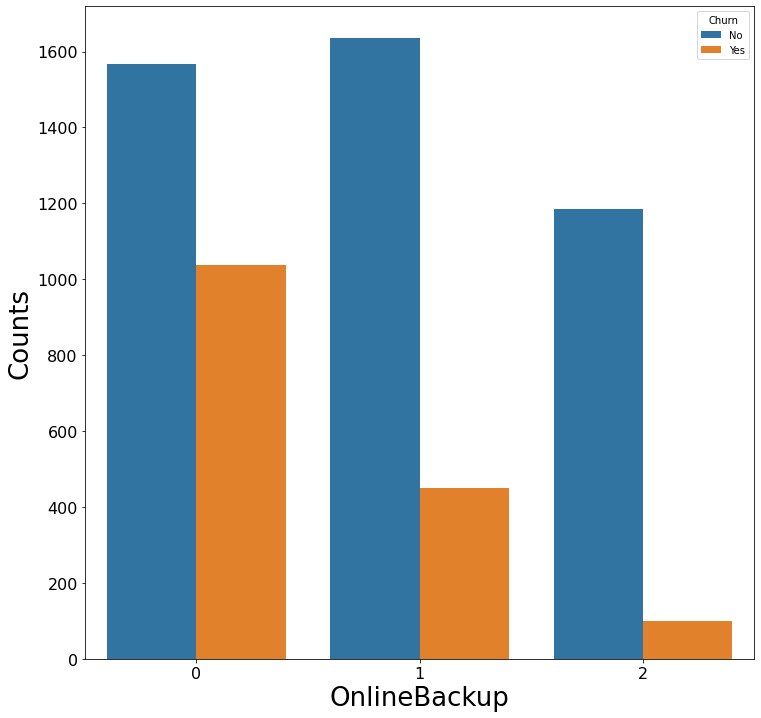

In [96]:
fig, ax = plt.subplots(figsize=(12,12))
ax=sns.countplot(data=df_dummy,x='OnlineBackup', ax=ax, hue='Churn')
ax.set_ylabel('Counts', fontsize=26)
ax.set_xlabel('OnlineBackup', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

Text(0.5, 0, 'OnlineSecurity')

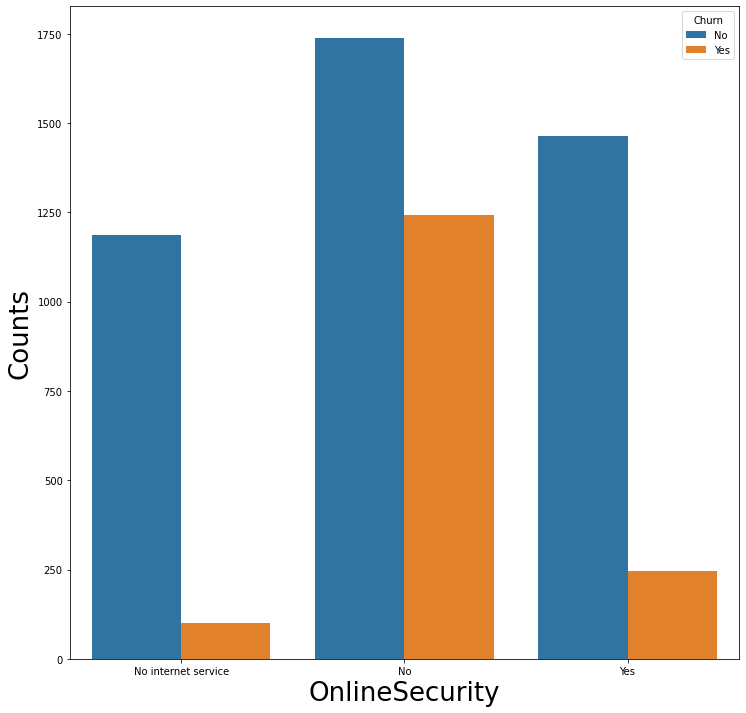

In [29]:
fig, ax = plt.subplots(figsize=(12,12))
ax=sns.countplot(data=df_dummy,x='OnlineSecurity', ax=ax, hue='Churn')
ax.set_ylabel('Counts', fontsize=26)
ax.set_xlabel('OnlineSecurity', fontsize=26)

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax=sns.countplot(data=df_dummy,x='OnlineBackup', ax=ax, hue='Churn')
ax.set_ylabel('Counts', fontsize=26)
ax.set_xlabel('OnlineBackup', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

Text(0.5, 0, 'TotalCharges')

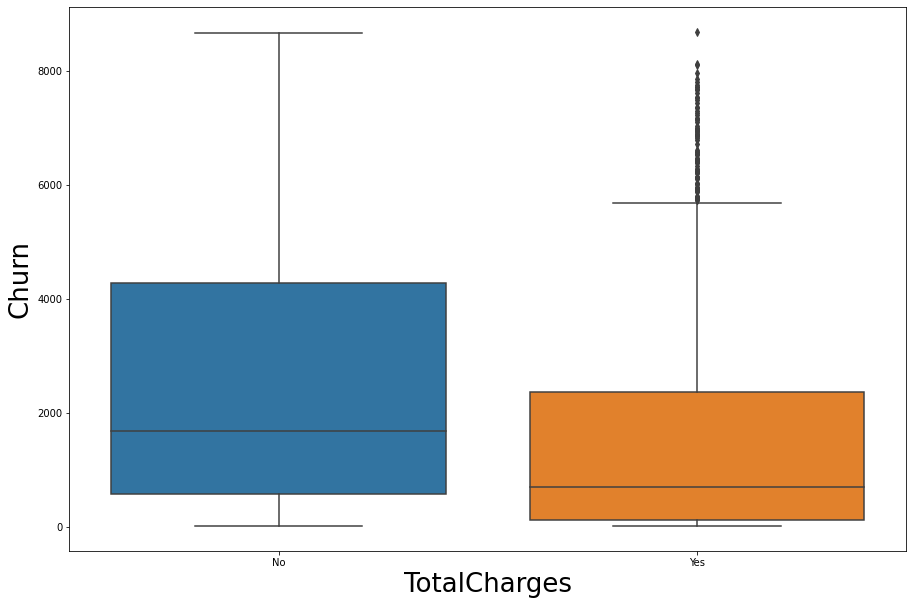

In [30]:
fig, ax = plt.subplots(figsize=(15,10))
ax=sns.boxplot(data=df_dummy, x='Churn', ax=ax, y='TotalCharges')
ax.set_ylabel('Churn', fontsize=26)
ax.set_xlabel('TotalCharges', fontsize=26)
#for c,i in enumerate(int_feat):
   
    #ax[c].set_title(i)

Text(0.5, 0, 'MonthlyCharges')

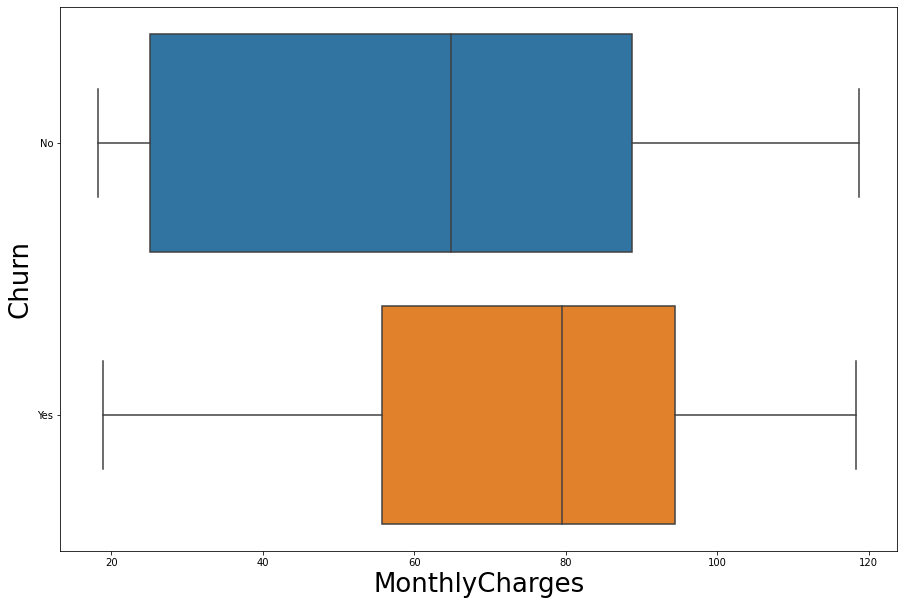

In [98]:
fig, ax = plt.subplots(figsize=(15,10))
ax=sns.boxplot(data=df_dummy,x='MonthlyCharges', y='Churn', ax=ax )
ax.set_ylabel('Churn', fontsize=26)
ax.set_xlabel('MonthlyCharges', fontsize=26)

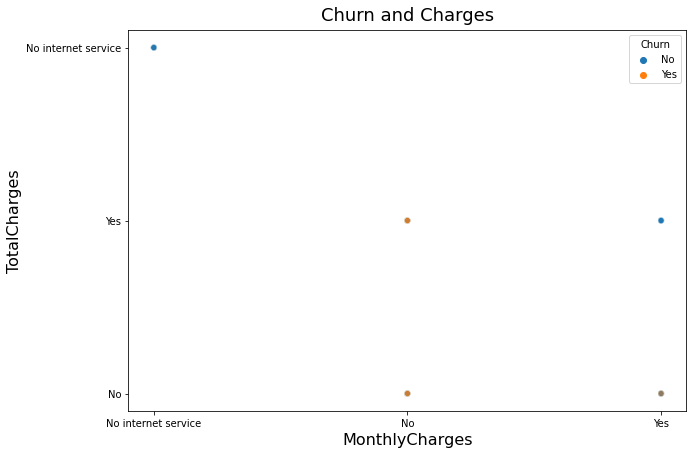

In [32]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_dummy, x='OnlineSecurity', y='OnlineBackup', hue='Churn', alpha=0.5,legend=True)
plt.title('Churn and Charges', fontsize=18, pad=10)
plt.ylabel('TotalCharges', fontsize=16)
plt.xlabel('MonthlyCharges', fontsize=16)
#plt.legend(fontsize=14)
plt.show()

In [33]:
df_num.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,5976.000000,5976.000000,5976.000000,5976.000000
mean,0.161647,32.523092,64.846687,2298.060617
std,0.368157,24.500858,30.107576,2274.127165
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.750000,404.312500
50%,0.000000,29.000000,70.425000,1412.150000
75%,0.000000,56.000000,89.900000,3846.962500
max,1.000000,72.000000,118.750000,8684.800000


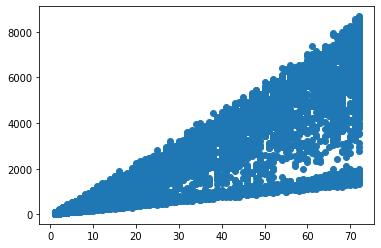

In [34]:
plt.scatter(df_num['tenure'],df_num['TotalCharges'])

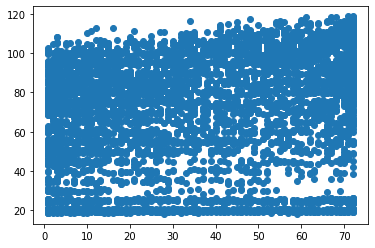

In [35]:
plt.scatter(df_num['tenure'],df_num['MonthlyCharges'])

## Encode
Yes:1

No:0

No internet service: 2

Male: 1

Female:0

In [36]:
df_dummy=clean_df

In [37]:
#Encode
df_dummy['gender'].replace({'Female': 0,'Male': 1},inplace=True)
df_temp=df[['customerID','InternetService']]
df_temp

,customerID,InternetService
1869,7010-BRBUU,No
4528,9688-YGXVR,Fiber optic
6344,9286-DOJGF,Fiber optic
6739,6994-KERXL,DSL
432,2181-UAESM,DSL
...,...,...
3772,0684-AOSIH,Fiber optic
5191,5982-PSMKW,DSL
5226,8044-BGWPI,No
5390,7450-NWRTR,Fiber optic


In [38]:
df_dummy=df_dummy.drop(columns='InternetService')
df_dummy.replace({'Yes': 1,'No': 0},inplace=True)
df_dummy.replace({'No phone service':2,'No internet service':2},inplace=True)

df_dummy=pd.merge(df_dummy,df_temp,on='customerID')
df_dummy.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService
0,7010-BRBUU,1,0,1,1,72,1,1,2,2,2,2,2,2,Two year,0,Credit card (automatic),24.10,1734.65,0,No
1,9688-YGXVR,0,0,0,0,44,1,0,0,1,1,0,1,0,Month-to-month,1,Credit card (automatic),88.15,3973.20,0,Fiber optic
2,9286-DOJGF,0,1,1,0,38,1,1,0,0,0,0,0,0,Month-to-month,1,Bank transfer (automatic),74.95,2869.85,1,Fiber optic
3,6994-KERXL,1,0,0,0,4,1,0,0,0,0,0,0,1,Month-to-month,1,Electronic check,55.90,238.50,0,DSL
4,2181-UAESM,1,0,0,0,2,1,0,1,0,1,0,0,0,Month-to-month,0,Electronic check,53.45,119.50,0,DSL


In [39]:
df_dummy_num=df_dummy.select_dtypes(exclude=['object'])
df_dummy_num.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,1,0,1,1,72,1,1,2,2,2,2,2,2,0,24.10,1734.65,0
1,0,0,0,0,44,1,0,0,1,1,0,1,0,1,88.15,3973.20,0
2,0,1,1,0,38,1,1,0,0,0,0,0,0,1,74.95,2869.85,1
3,1,0,0,0,4,1,0,0,0,0,0,0,1,1,55.90,238.50,0
4,1,0,0,0,2,1,0,1,0,1,0,0,0,0,53.45,119.50,0


TypeError: ignored

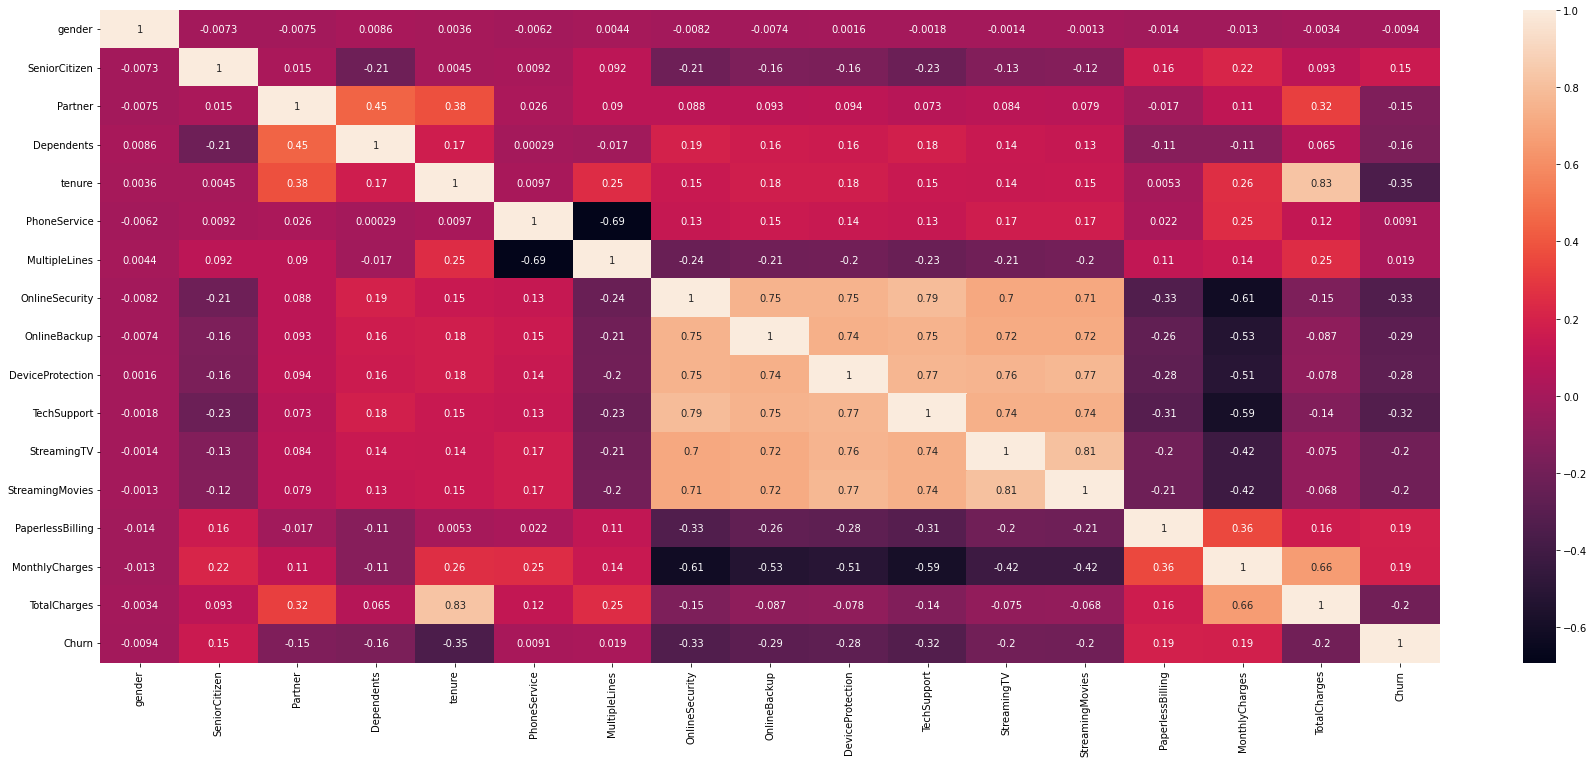

In [95]:
corr=df_dummy_num.corr()
f, ax = plt.subplots(figsize=(30, 12))
ax = sns.heatmap(corr, annot=True)
#ax.set_xlabel(fontdict=1)
#sns.set(font_scale=0.1)

## Feature selection

Delete high correlation feature

In [41]:
df_dummy.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService
0,7010-BRBUU,1,0,1,1,72,1,1,2,2,2,2,2,2,Two year,0,Credit card (automatic),24.10,1734.65,0,No
1,9688-YGXVR,0,0,0,0,44,1,0,0,1,1,0,1,0,Month-to-month,1,Credit card (automatic),88.15,3973.20,0,Fiber optic
2,9286-DOJGF,0,1,1,0,38,1,1,0,0,0,0,0,0,Month-to-month,1,Bank transfer (automatic),74.95,2869.85,1,Fiber optic
3,6994-KERXL,1,0,0,0,4,1,0,0,0,0,0,0,1,Month-to-month,1,Electronic check,55.90,238.50,0,DSL
4,2181-UAESM,1,0,0,0,2,1,0,1,0,1,0,0,0,Month-to-month,0,Electronic check,53.45,119.50,0,DSL


In [42]:
df_dummy=df_dummy.drop(columns='customerID')
#df_dummy['Contract']=df_dummy['Contract'].replace({'Month-to-month':2,'Two year':1, 'One year':0},inplace=True)
#df_dummy['InternetService']=df_dummy['InternetService'].replace({'No':0, 'Fiber optic':1, 'DSL':2},inplace=True)
#df_dummy['PaymentMethod']=df_dummy['PaymentMethod'].replace({'Credit card (automatic)' 'Bank transfer (automatic)' 'Electronic check''Mailed check'},inplace=True)

In [43]:
X = df_dummy.drop(columns=['Churn','gender','PhoneService'])
y = df_dummy["Churn"]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4183, 17) (4183,) (1793, 17) (1793,)


In [45]:
X_train.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService
2189,0,1,1,58,1,1,1,0,0,0,1,Month-to-month,1,Bank transfer (automatic),93.40,5435.60,Fiber optic
1088,0,1,0,70,1,0,1,1,1,1,0,Two year,0,Bank transfer (automatic),72.95,5265.55,DSL
4609,1,0,0,1,0,0,0,0,0,1,0,Month-to-month,0,Electronic check,78.45,78.45,Fiber optic
2488,0,0,0,17,0,0,0,0,0,0,0,Month-to-month,0,Bank transfer (automatic),70.50,1165.60,Fiber optic
3206,0,0,1,1,0,0,0,0,0,0,0,Month-to-month,0,Mailed check,45.95,45.95,DSL


In [46]:
#categorical_features = X_train.select_dtypes("object").columns.to_list()
numeric_features = ['tenure','MonthlyCharges','TotalCharges']
#categorical_features = X_train[''].columns.to_list()
categorical_features=X_train.drop(columns=['tenure','MonthlyCharges','TotalCharges']).columns.to_list()
print("Num of categorical features:", len(categorical_features))
print("Num of numeric features:", len(numeric_features))

Num of categorical features: 14
Num of numeric features: 3


In [47]:
# Categorical features
categorical_transformer = Pipeline(steps=[
                                          ("onehot", OneHotEncoder(handle_unknown="ignore"))
                                          ])

In [48]:
# Numeric features
numeric_transformer = Pipeline(steps=[
                                      ("knn_imputer", KNNImputer(n_neighbors=5)),
                                      ("scaler", StandardScaler())
                                      ])

In [49]:
# Column transformer
preprocessor = ColumnTransformer(transformers=[
                                               ("num", numeric_transformer, 
                                                       numeric_features),
                                               ("cat", categorical_transformer, 
                                                       categorical_features)
                                               ])

In [50]:
#test by logisticregression
logistic = LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced')
  
pipeline = Pipeline(steps=[
                            ("pre_process", preprocessor), 
                            ("model", logistic)
                            ])



In [51]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# Confussion matrix
class_labels = pipeline.named_steps['model'].classes_

pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=class_labels, index=class_labels)

,0,1
0,947,344
1,101,401


In [52]:
# Classification report
comp = classification_report(y_test, y_pred)
print(comp)

              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1291
           1       0.54      0.80      0.64       502

    accuracy                           0.75      1793
   macro avg       0.72      0.77      0.73      1793
weighted avg       0.80      0.75      0.76      1793



Add feature: number of service

In [53]:
df_dummy.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService
0,1,0,1,1,72,1,1,2,2,2,2,2,2,Two year,0,Credit card (automatic),24.10,1734.65,0,No
1,0,0,0,0,44,1,0,0,1,1,0,1,0,Month-to-month,1,Credit card (automatic),88.15,3973.20,0,Fiber optic
2,0,1,1,0,38,1,1,0,0,0,0,0,0,Month-to-month,1,Bank transfer (automatic),74.95,2869.85,1,Fiber optic
3,1,0,0,0,4,1,0,0,0,0,0,0,1,Month-to-month,1,Electronic check,55.90,238.50,0,DSL
4,1,0,0,0,2,1,0,1,0,1,0,0,0,Month-to-month,0,Electronic check,53.45,119.50,0,DSL


Delete more features

In [54]:
df_dummy.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService
0,1,0,1,1,72,1,1,2,2,2,2,2,2,Two year,0,Credit card (automatic),24.10,1734.65,0,No
1,0,0,0,0,44,1,0,0,1,1,0,1,0,Month-to-month,1,Credit card (automatic),88.15,3973.20,0,Fiber optic
2,0,1,1,0,38,1,1,0,0,0,0,0,0,Month-to-month,1,Bank transfer (automatic),74.95,2869.85,1,Fiber optic
3,1,0,0,0,4,1,0,0,0,0,0,0,1,Month-to-month,1,Electronic check,55.90,238.50,0,DSL
4,1,0,0,0,2,1,0,1,0,1,0,0,0,Month-to-month,0,Electronic check,53.45,119.50,0,DSL


In [55]:
X = df_dummy.drop(columns=['Churn','gender','PhoneService','TotalCharges','OnlineSecurity',	'DeviceProtection',	'TechSupport','StreamingTV','StreamingMovies'])
y = df_dummy["Churn"]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4183, 11) (4183,) (1793, 11) (1793,)


In [57]:
numeric_features = ['tenure','MonthlyCharges']
#categorical_features = X_train[''].columns.to_list()
categorical_features=X_train.drop(columns=['tenure','MonthlyCharges']).columns.to_list()
print("Num of categorical features:", len(categorical_features))
print("Num of numeric features:", len(numeric_features))

Num of categorical features: 9
Num of numeric features: 2


In [58]:
# Categorical features
categorical_transformer = Pipeline(steps=[
                                          ("onehot", OneHotEncoder(handle_unknown="ignore"))
                                          ])

In [59]:
# Numeric features
numeric_transformer = Pipeline(steps=[
                                      ("knn_imputer", KNNImputer(n_neighbors=5)),
                                      ("scaler", StandardScaler())
                                      ])

In [60]:
# Column transformer
preprocessor = ColumnTransformer(transformers=[
                                               ("num", numeric_transformer, 
                                                       numeric_features),
                                               ("cat", categorical_transformer, 
                                                       categorical_features)
                                               ])

In [61]:
#test by logisticregression
logistic = LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced')
  
pipeline = Pipeline(steps=[
                            ("pre_process", preprocessor), 
                            ("model", logistic)
                            ])

In [62]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# Confussion matrix
class_labels = pipeline.named_steps['model'].classes_

pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=class_labels, index=class_labels)

,0,1
0,956,377
1,101,359


In [63]:
# Classification report
comp = classification_report(y_test, y_pred)
print(comp)

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1333
           1       0.49      0.78      0.60       460

    accuracy                           0.73      1793
   macro avg       0.70      0.75      0.70      1793
weighted avg       0.80      0.73      0.75      1793



Try all categories

In [64]:
df_dummy.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService
0,1,0,1,1,72,1,1,2,2,2,2,2,2,Two year,0,Credit card (automatic),24.10,1734.65,0,No
1,0,0,0,0,44,1,0,0,1,1,0,1,0,Month-to-month,1,Credit card (automatic),88.15,3973.20,0,Fiber optic
2,0,1,1,0,38,1,1,0,0,0,0,0,0,Month-to-month,1,Bank transfer (automatic),74.95,2869.85,1,Fiber optic
3,1,0,0,0,4,1,0,0,0,0,0,0,1,Month-to-month,1,Electronic check,55.90,238.50,0,DSL
4,1,0,0,0,2,1,0,1,0,1,0,0,0,Month-to-month,0,Electronic check,53.45,119.50,0,DSL


In [65]:
def f(x):
  if x <= 20:
    return 1
  elif (x <= 60) & (x > 20):
    return 2
  elif (x <= 100) & (x > 60):
    return 3
  elif x > 100:
    return 4
  

In [66]:
df_dummy['tenure_class']=df_dummy['tenure'].apply(lambda x: x//12)
df_dummy['tenure_class'].unique()

array([6, 3, 0, 5, 2, 4, 1])

In [67]:
df_dummy['MonthlyCharges_class']=df_dummy['MonthlyCharges'].apply(lambda x: f(x))

In [68]:
df_dummy.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService,tenure_class,MonthlyCharges_class
0,1,0,1,1,72,1,1,2,2,2,2,2,2,Two year,0,Credit card (automatic),24.10,1734.65,0,No,6,2
1,0,0,0,0,44,1,0,0,1,1,0,1,0,Month-to-month,1,Credit card (automatic),88.15,3973.20,0,Fiber optic,3,3
2,0,1,1,0,38,1,1,0,0,0,0,0,0,Month-to-month,1,Bank transfer (automatic),74.95,2869.85,1,Fiber optic,3,3
3,1,0,0,0,4,1,0,0,0,0,0,0,1,Month-to-month,1,Electronic check,55.90,238.50,0,DSL,0,2
4,1,0,0,0,2,1,0,1,0,1,0,0,0,Month-to-month,0,Electronic check,53.45,119.50,0,DSL,0,2


In [69]:
X = df_dummy.drop(columns=['Churn','gender','PhoneService','TotalCharges','tenure','MonthlyCharges'])
y = df_dummy["Churn"]

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4183, 16) (4183,) (1793, 16) (1793,)


In [71]:
#numeric_features = ['tenure','MonthlyCharges']
#categorical_features = X_train[''].columns.to_list()
categorical_features=X_train.columns.to_list()
print("Num of categorical features:", len(categorical_features))
#print("Num of numeric features:", len(numeric_features))

Num of categorical features: 16


In [72]:
# Categorical features
categorical_transformer = Pipeline(steps=[
                                          ("onehot", OneHotEncoder(handle_unknown="ignore"))
                                          ])

In [73]:
# Column transformer
preprocessor = ColumnTransformer(transformers=[
                                               ("cat", categorical_transformer, 
                                                       categorical_features)
                                               ])

In [74]:
#test by logisticregression
logistic = LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced')
  
pipeline = Pipeline(steps=[
                            ("pre_process", preprocessor), 
                            ("model", logistic)
                            ])

In [75]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# Confussion matrix
class_labels = pipeline.named_steps['model'].classes_

pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=class_labels, index=class_labels)

,0,1
0,964,372
1,103,354


In [76]:
# Classification report
comp = classification_report(y_test, y_pred)
print(comp)

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1336
           1       0.49      0.77      0.60       457

    accuracy                           0.74      1793
   macro avg       0.70      0.75      0.70      1793
weighted avg       0.80      0.74      0.75      1793

